<a href="https://colab.research.google.com/github/carturo6/Covid-19/blob/master/LSTM_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I.A. DeepLearnin para Casos Covid-19**

Este respositorio tiene el fin de predecir los proximo casos de Covid19 en México ( Nivel nacional ).

Los datos que se ocuparan, son los datos disponibles en paginas del Gobierno.
Se utilizaran solo tecnicas de Deep Learning donde cada modelo podra ir variando en funcion que los datos predichos mejor se ajusten a los datos predictorios.

**Objetivo de las redes neuronales**

El objetivo de los modelos que se construiran, sera, que mejor se ajusten a los datos de test (Prueba) para poder predecir los datos del futuro. En funcion de que mejor se ajusten, sigfinicara que el entrenamiento sera exitoso.

Se ocuparan modelos de Deep Learning, para ajustarse a los datos y tener buenos resultados. La tecnica que mas probable se ajusta a las predicciones de series de tiempo, es LSTM (**Long Short Term Memory**).

## **Librerias**


Las librerias que se ocupan son las siguientes:

- Pandas: Para poder leer los archivos csv o en algun otro formato, asi como para poder manipular los datos.

- Matplotlib: Para generar graficos y asi poder entender mejor el comportamiento de la pandemia en Mexico.

- Numpy: Para poder realizar calculo que se puedan requerir o calculo de matrices

- Seaborn: Para generar graficos estadisticos con una mejor referencia de los datos

- Tensorflow: Para poder generar predicciones con redes nueronales de esta libreria

- Keras: Generar CNN para las predicciones

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from scipy import stats


from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras import metrics
from tensorflow import keras


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Importacion de datos**


Los datos ocupados en este trabajo, se tomaron de la siguiente pagina web: 

Este dataset contempla los datos disponibles de varios paises, pero simplemente se filtraran los datos correspondientes a Mexico.


In [2]:
# Carga del Dataset My path
df = pd.read_csv('/content/drive/MyDrive/GitHub/LSTM-Covid-19/owid-covid-data.csv')

In [3]:
# Filtrando los datos, solo para Mexico
df_mx = df[df['location'] == 'Mexico']
#Mostrando el resultado
df_mx.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45393,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,0.000,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45394,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,97.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45395,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,186.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45396,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,231.0,0.002,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45397,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,316.0,0.002,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779


In [4]:
# Seleccionando columnas
df_mx = df_mx.iloc[:, 3:6]
df_mx.head()

,date,total_cases,new_cases
45393,2020-01-01,NaN,NaN
45394,2020-01-02,NaN,NaN
45395,2020-01-03,NaN,NaN
45396,2020-01-04,NaN,NaN
45397,2020-01-05,NaN,NaN


In [5]:
#Reseteando index
df_mx = df_mx.reset_index(inplace=False)
#Eliminando columna extra
del df_mx['index']
#Mostrando datos
df_mx.head(3)

,date,total_cases,new_cases
0,2020-01-01,NaN,NaN
1,2020-01-02,NaN,NaN
2,2020-01-03,NaN,NaN


In [6]:
# Trabajando con la columna de nuevos casos
df_mx = df_mx.iloc[:,[0,2]]
df_mx.head()

,date,new_cases
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN
3,2020-01-04,NaN
4,2020-01-05,NaN


Asi seran los datos con los que se trabajaran. 

Como se muestran en la tabla de arriba.

## **Transformacion de los datos**

Es importante considerar, que para poder realizar predicciones, los datos debe de tener una forma correcta, es decir:


- No tener datos faltantes
- La fecha sera de tipo datetime
- Los datos de "nuevo casos" son datos numericos


---


Realizar un analisis estadistico, es importante para poder contemplar el comportamineto de los daots.





In [7]:
df_mx.head(3)

,date,new_cases
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN


In [8]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       454 non-null    object 
 1   new_cases  396 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.2+ KB


In [9]:
df_mx.date = pd.to_datetime(df_mx.date)

In [10]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       454 non-null    datetime64[ns]
 1   new_cases  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 KB


In [11]:
#Analisis estadistico rapido
df_mx.describe()

,new_cases
count,396.000000
mean,5625.866162
std,4475.211614
min,0.000000
25%,2800.250000
50%,5237.500000
75%,6848.500000
max,28115.000000


In [12]:
df_mx.isna().sum()

date          0
new_cases    58
dtype: int64

In [13]:
# Quitando Datos faltantes.
df_mx = df_mx[df_mx['new_cases'].notna()]

In [14]:
df_mx.tail()

,date,new_cases
449,2021-03-25,5787.0
450,2021-03-26,5303.0
451,2021-03-27,5059.0
452,2021-03-28,1646.0
453,2021-03-29,1293.0


In [15]:
df_mx.date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     396
unique                    396
top       2020-04-13 00:00:00
freq                        1
first     2020-02-28 00:00:00
last      2021-03-29 00:00:00
Name: date, dtype: object


---


---


## **Visualizacion de Datos**


Es muy importante poder ver los datos de manera grafica, asi se podra tener vision mas clara del comportamiento de los datos.

Al tratar con datos, que se trabajaran como series temporales, existe un tipo de grafico que mas se adopta a estos mismos. Plotear datos es una forma clara para ver su comportamiento. 

Por el eje de las x, tenemos el tiempo, los dias o meses que han transcurrido. En el eje de las y, tenemos la cantidad de casos nuevos, de esta forma es como se puede ver su comportamiento.

**Para la tendencia. Los datos se trabajaran con una serie de tiempo de 7 dias (1 semana), para acomular la mayor cantidad de datos y aun asi podamos tener buenas predicciones**

En las graficas se trabajan con las series temporales de 7 dias juntos.

In [16]:
#Copiando dataset
df_mx_2 = df_mx.copy()

In [17]:
df_mx_2.set_index('date', inplace=True)

In [18]:
# Promedio de ventanas de tiempo

#Ventana de tiempo
ventana_tiempo = df_mx_2.rolling(7)

#Media de la ventana de tiempo
media_df = ventana_tiempo.mean()

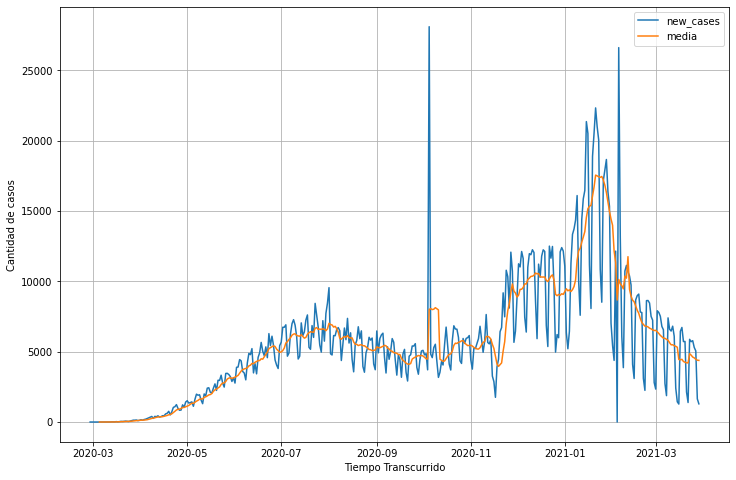

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df_mx_2, label='new_cases')
plt.plot(media_df, label='media')
plt.ylabel('Cantidad de casos')
plt.xlabel('Tiempo Transcurrido')
plt.grid()
plt.legend()

**Los datos presentados en la grafica presentan algunos outliers (datos fuera de lo normal), estos datos se pueden ver en la grafica de arribsa, entre el mes 09 y 11. Tambien entre 2021-01 y 2021-03. Estos datos son muy notorios ya que tienen una exageración dentro de la grafica.**



**Pero para poder observar otra perseptiva de los datos, veremos su tendencia, ya que la tendencia podra revelar los datos aun mas claros.**

In [20]:
seasonal_value = seasonal_decompose(df_mx_2, freq=7)

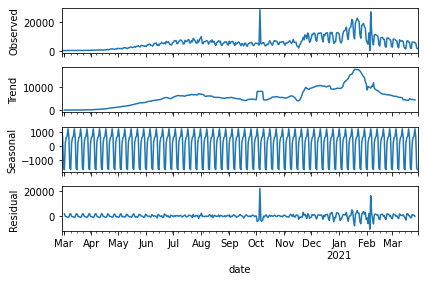

In [21]:
seasonal_value.plot();

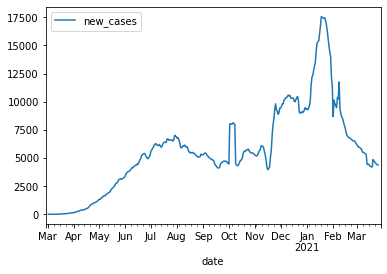

In [22]:
seasonal_value.trend.plot()

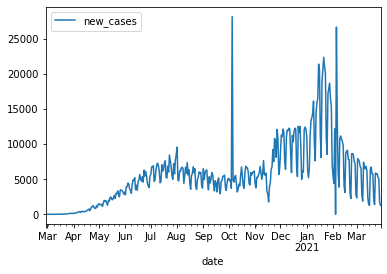

In [23]:
seasonal_value.observed.plot()

Observando si la froma de los datos, es normal o no es normal.

- Si p <= alpha  **No es normal**
- Si p > alpha **Es normal**

Donde se va a conciderar alpha como 0.55

In [25]:
stat, p = stats.normaltest(df_mx_2.new_cases)
print('Statics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Forma Gausiana')
else:
    print('No tiene forma gausiana')

Statics=131.357, p=0.000
No tiene forma gausiana


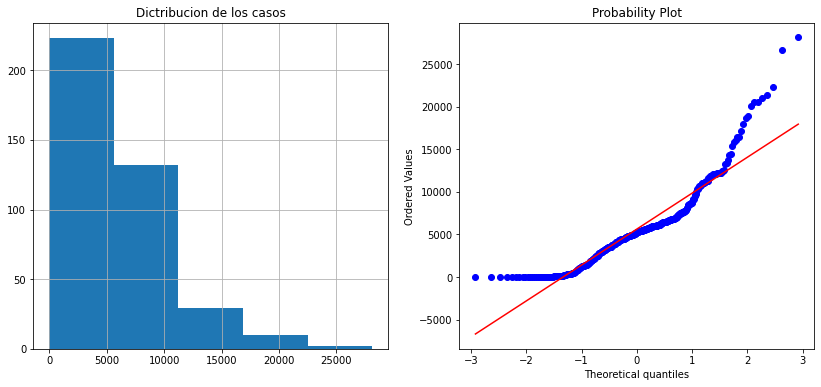

In [26]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
df_mx_2['new_cases'].hist(bins=5)
plt.title('Dictribucion de los casos')

plt.subplot(1,2,2)
stats.probplot(df_mx_2['new_cases'], plot=plt);


# **Escalando datos**

Preparando los datos para poder introducirlos a las diferetnes redes nueronales

- Unas vez visualizados algunos de los datos, procederemos a realizar una division de los datos, en 2 conjuntos, entreanmiento y prueba. De esta forma tendremos una mejor prediccion, para poder tener una referenecia entre los datos de testeo y las predicciones. Asi se podra observar como sera la sertesa de la prediccion vs datos reales.

- De manera mas practica y con la intencion de tener una mejor idea, los resultados se estaran ploteando(graficando) y asi ver como nos asercamos a las predicciones.

- Para todos los datos para predecir tomaremos unicamente 20 dias para predecir en el futuro. 20 datos son los que apartaremos para testeo.

In [42]:
# Datos de entreamiento y test
len(df_mx_2)

396

In [46]:
# 90% Datos
len(df_mx_2) * 90 // 100

356

In [45]:
#Division de los datos de entrenamiento y test
train = df_mx_2.iloc[:len(df_mx_2) * 90 // 100]
test = df_mx_2.iloc[len(df_mx_2) * 90 // 100:]

In [53]:
print(len(train))
print(len(test))

356
40


In [51]:
# Escalando datos

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

scaler = MinMaxScaler()

In [52]:
#Ajustando los datos de entrenamiento
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train

In [55]:
# Generator
n_input = 40
n_feacture = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

x, y = generator[0]

# **Arquitectura 1**

In [74]:
#Esta funcion, sera util para la primera arquitectura. Para la 2a, no
# 1. Funcion se encargara de realizar las predicciones por lotes
# 2. De las predicciones, realizar la inversa
def function_preparet(model, n_input = 40, n_feacture = 1):
    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval.reshape((1, n_input, n_feacture))

    for i in range(len(test)):

        # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
        current_pred = model.predict(current_batch)[0]

        # guardar la predicción
        test_predictions.append(current_pred) 

        # actualizar el lote para incluir ahora la predicción y soltar primer valor
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    #Transofmacion inversa
    true_predicctions = scaler.inverse_transform(test_predictions)
    return true_predicctions

# **Generacion de Modelos**

- En esta seccion se podran obseervar el proceso de creacion de modelos predictivos para los datos

    - Creacion del modelo
    - Entrenamiento del modelos
    - Visualizando predccicion y datos reales
    - Observar en accuracy

## **Modelo 1**

In [61]:
# Red neuronal
# MODELO 1

# 1. Creacion Modelo
model_1 = Sequential()

#Modelo ocupara 4 capas
#Optmizador: adam
#Funcion de perdidad: mean_squarer_error
model_1.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_1.add(Dense(64, activation='relu' ))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(1))

# 2. Compilacion del modelo
model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# 3. Entreneamiento del modelo
model_1.fit_generator(generator, epochs=50)

In [62]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


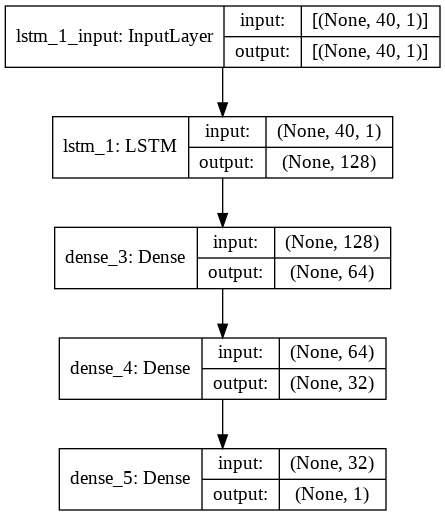

In [101]:
keras.utils.plot_model(model_1, show_shapes=True)

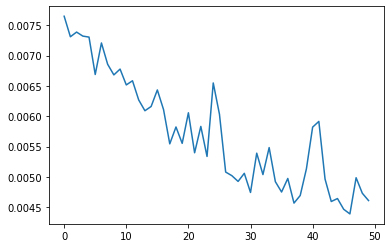

In [77]:
# Plotenado las datos de perdida
loss_pre_epoch = model_1.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

In [78]:
first_eval = scaled_train[-40:]
first_eval = first_eval.reshape(1, n_input, n_feacture)
model_1.predict(first_eval)

array([[0.28323323]], dtype=float32)

In [79]:
y = function_preparet(model_1)

In [80]:
test['Model_1'] = y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [81]:
#Observando predicciones vs datos reales
#observamos las primeras 8 filas
test.head(8)

,new_cases,Model_1
date,,
2021-02-18,9099.0,7963.102131
2021-02-19,7829.0,6906.965707
2021-02-20,7785.0,5458.524759
2021-02-21,3104.0,4649.039109
2021-02-22,2252.0,4489.422302
2021-02-23,8634.0,4685.483653
2021-02-24,8642.0,4931.165404
2021-02-25,8462.0,5157.008379


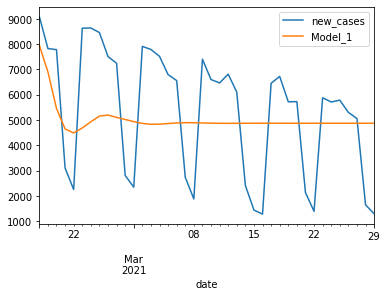

In [82]:
#Plotenado datos Predictores y predichos
test.plot()

## **Modelo 2**

In [ ]:
# Modelo 2
# Modelo con 5 capas
# Optmizador: SGD
# Funcion de perdida: MSE

# 1. Creacion del modelo
model_2 = Sequential()

model_2.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_2.add(Dense(64, activation='relu' ))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(12, activation='relu'))
model_2.add(Dense(1))

# 2. Compilacion del modelo
model_2.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])

# 3. Entrenamiento del modelo
model_2.fit_generator(generator, epochs=50)

In [88]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 12)                396       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 13        
Total params: 77,305
Trainable params: 77,305
Non-trainable params: 0
_________________________________________________________________


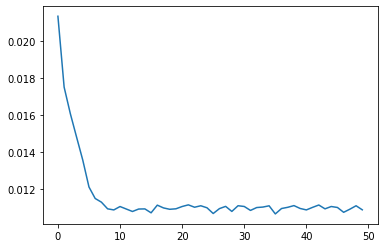

In [89]:
# Plotenado datos de perdida
loss_pre_epoch = model_2.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

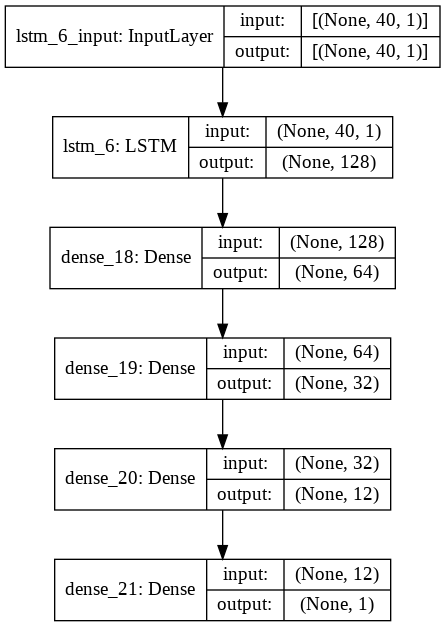

In [91]:
# Observando el comportamiento de la Red Nueronal
keras.utils.plot_model(model_2, show_shapes=True)

In [92]:
first_eval = scaled_train[-40:]
first_eval = first_eval.reshape(1, n_input, n_feacture)
model_2.predict(first_eval)

array([[0.27706033]], dtype=float32)

In [93]:
# Accedemos a la funcion para prededir por lotes
y = function_preparet(model_2)

In [95]:
# Asigna los datos a nueva columna
test['Model_2'] = y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


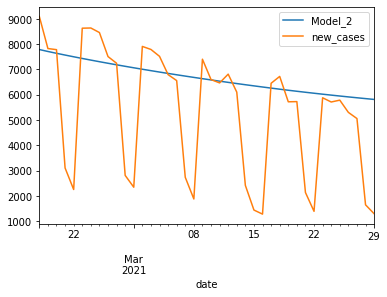

In [97]:
test[['Model_2', 'new_cases']].plot()

In [100]:
#Observacion de los test y la predicciones
test.head(8)

,new_cases,Model_1,Model_2
date,,,
2021-02-18,9099.0,7963.102131,7789.551176
2021-02-19,7829.0,6906.965707,7712.967820
2021-02-20,7785.0,5458.524759,7641.120231
2021-02-21,3104.0,4649.039109,7571.307046
2021-02-22,2252.0,4489.422302,7503.219080
2021-02-23,8634.0,4685.483653,7436.761653
2021-02-24,8642.0,4931.165404,7371.939791
2021-02-25,8462.0,5157.008379,7308.500452


# **Modeo 3**

In [ ]:
# Red neuronal 3
# 5 Capas
# relu para activacion de cada capa
# sgd para compilacion y mse para loss

#Red sequential
model_3 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_3.add(LSTM(168, activation='relu', input_shape=(n_input, n_feacture)))
model_3.add(Dense(124, activation='relu' ))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32))
model_3.add(Dense(1))

#Compilacion de la red nueronal
model_3.compile(optimizer='sgd', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [ ]:
model_3.summary()

In [ ]:
#Entrenando la red nueronal

model_3.fit_generator(generator, epochs=100)

In [ ]:
first_eval_3 = scaled_train[-20:]


first_eval_3 = first_eval_3.reshape(1, n_input, n_feacture)

model_3.predict(first_eval_3)

In [ ]:
test_predictions_3 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_3.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_3.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_3.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_3 = scaler.inverse_transform(test_predictions_3)


test['Prediction_3'] = true_predicctions_3

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
#Observacion de los test y la predicciones
test

# **Modelo 4**

In [ ]:
# Red neuronal 4
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_4 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_4.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_4.add(Dense(100, activation='relu' ))
model_4.add(Dense(84, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(32))
model_4.add(Dense(1))

#Compilacion de la red nueronal
model_4.compile(optimizer='adam', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [ ]:
model_4.summary()

In [ ]:
#Entrenando la red nueronal

model_4.fit_generator(generator, epochs=200)

In [ ]:
first_eval_4 = scaled_train[-20:]


first_eval_4 = first_eval_4.reshape(1, n_input, n_feacture)

model_4.predict(first_eval_4)

In [ ]:
test_predictions_4 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_4.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_4.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_4.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_4 = scaler.inverse_transform(test_predictions_4)


test['Prediction_4'] = true_predicctions_4

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
#Observacion de los test y la predicciones
test

# **Model 5**

In [ ]:
# Red neuronal 5
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_5 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_5.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_5.add(Dense(100, activation='relu' ))
model_5.add(Dense(84, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='sigmoid'))
model_5.add(Dense(1))

#Compilacion de la red nueronal
model_5.compile(optimizer='adam', loss='mean_squared_error',
                metrics=["accuracy"])

In [ ]:
model_5.summary()

In [ ]:
#Entrenando la red nueronal

model_5.fit_generator(generator, epochs=200)

In [ ]:
first_eval_5 = scaled_train[-20:]


first_eval_5 = first_eval_5.reshape(1, n_input, n_feacture)

model_5.predict(first_eval_5)

In [ ]:
test_predictions_5 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_5.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_5.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_5.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_5 = scaler.inverse_transform(test_predictions_5)


test['Prediction_5'] = true_predicctions_5

In [ ]:
test[['new_cases', 'Prediction_5']].plot(figsize=(12,8))

In [ ]:
#Observacion de los test y la predicciones
test

# **Modelo 6**

In [ ]:
# Red neuronal 6
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_6 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_6.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_6.add(Dense(150, activation='relu' ))
model_6.add(Dense(100, activation='relu'))
model_6.add(Dense(80, activation='relu'))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='sigmoid'))
model_6.add(Dense(1))

#Compilacion de la red nueronal
model_6.compile(optimizer='adam', loss='mean_squared_error',
                metrics=["accuracy"])

In [ ]:
model_6.summary()

In [ ]:
#Entrenando la red nueronal

model_6.fit_generator(generator, epochs=250)

In [ ]:
first_eval_6 = scaled_train[-20:]


first_eval_6 = first_eval_6.reshape(1, n_input, n_feacture)

model_6.predict(first_eval_6)

In [ ]:
test_predictions_6 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_6.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_6.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_6.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_6 = scaler.inverse_transform(test_predictions_6)


test['Prediction_6'] = true_predicctions_6

In [ ]:
test[['new_cases', 'Prediction_6']].plot(figsize=(12,8))

In [ ]:
#Observacion de los test y la predicciones
test

# **Modelo 7**

In [ ]:
66/2

In [ ]:
# Red neuronal 7
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_7 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_7.add(LSTM(120, activation='relu', input_shape=(n_input, n_feacture)))
model_7.add(Dense(100, activation='relu' ))
model_7.add(Dense(68, activation='relu' ))
model_7.add(Dense(34, activation='sigmoid' ))
model_7.add(Dense(16, activation='sigmoid' ))
model_7.add(Dense(1))

#Compilacion de la red nueronal
model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mse',
                metrics=["accuracy"])

In [ ]:
model_7.summary()

In [ ]:
#Entrenando la red nueronal

model_7.fit_generator(generator, epochs=300)

In [ ]:
keras.utils.plot_model(model_7, "model_7.png", show_shapes=True)

In [ ]:
first_eval_7 = scaled_train[-20:]


first_eval_7 = first_eval_7.reshape(1, n_input, n_feacture)

model_7.predict(first_eval_7)

In [ ]:
test_predictions_7 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_7.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_7.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_7.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Transofmacion inversa
true_predicctions_7 = scaler.inverse_transform(test_predictions_7)


test['Prediction_7'] = true_predicctions_7

In [ ]:
test.plot(figsize=(12,8))
plt.title('Red nueronal predict')

In [ ]:
#Observacion de los test y la predicciones
test

In [ ]:
sea = seasonal_decompose(test['Prediction_7'])
sea.plot();

In [ ]:
sea.trend.plot()